In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, normalizers
import pandas as pd

from tensorflow.keras import mixed_precision as mixed_precision # Added 24052024
from tensorflow.keras.regularizers import l2


policy = mixed_precision.Policy('mixed_float16') # Added 24052024
mixed_precision.set_global_policy(policy) # 24052024

print(tf.__version__)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-05-29 00:37:09.559029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 00:37:09.559136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 00:37:09.710462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv
/kaggle/input/glove6b300d/glove.6B.300d.txt


In [2]:
from datetime import datetime

start = datetime.now()
print(start)

df_train = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
df_train.head()

2024-05-29 00:37:20.568292


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [3]:
len(df_train)

17307

In [4]:
df_aug = df_train.copy(deep=True)

df_aug['full_text'] = np.NaN

In [5]:
print(df_aug)

      essay_id  full_text  score
0      000d118        NaN      3
1      000fe60        NaN      3
2      001ab80        NaN      4
3      001bdc0        NaN      4
4      002ba53        NaN      3
...        ...        ...    ...
17302  ffd378d        NaN      2
17303  ffddf1f        NaN      4
17304  fff016d        NaN      2
17305  fffb49b        NaN      1
17306  fffed3e        NaN      2

[17307 rows x 3 columns]


In [6]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors

# Load pre-trained GloVe word vectors (you need to download the GloVe embeddings file beforehand)
glove_file = '/kaggle/input/glove6b300d/glove.6B.300d.txt'

print("Loading word vectors\n")
word_vectors = KeyedVectors.load_word2vec_format(fname = glove_file, binary=False, unicode_errors='ignore', no_header=True, limit=300000) # limit increased 28/05/2024
print("Word vectors loaded\n")

from tqdm import tqdm

print("Precomputing similar words\n")
similar_words_dict = {}
for word in word_vectors.index_to_key:
    similar_words_dict[word] = word_vectors.most_similar(word, topn=1)[0][0]
print("Precompute complete\n")    

# Define text augmentation function using GloVe embeddings
def augment_text_with_glove(text, similar_words_dict):
    augmented_text = []
    for word in text.split():
        if word in similar_words_dict:                        
            augmented_text.append(similar_words_dict[word])
        else:
            augmented_text.append(word)  # If the word is not in GloVe vocabulary, keep the original word
    return ' '.join(augmented_text)

print("Starting data augmentation now\n")
aug_start = datetime.now()
print("Augmentation start time is: ", aug_start)


# Apply text augmentation to the DataFrame
df_aug['full_text'] = df_train['full_text'].apply(lambda x: augment_text_with_glove(x, similar_words_dict))

aug_end = datetime.now()
print("\nAugmentation end time is: ", aug_end)
print("\nData augmentation complete")

Loading word vectors

Word vectors loaded

Precomputing similar words

Precompute complete

Starting data augmentation now

Augmentation start time is:  2024-05-29 02:19:13.880547

Augmentation end time is:  2024-05-29 02:19:16.127831

Data augmentation complete


In [7]:
df_train_fin = pd.concat([df_train, df_aug], axis=0)
len(df_train_fin)

34614

In [8]:
df_train_fin['score'] = df_train_fin['score'] - 1

In [9]:
df_train_fin['full_text'].map(len).mean()

2181.0156872941584

In [10]:
import spacy
# Load the English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

# Function to apply lemmatization
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [11]:
print("\nApplying lemmatization now")
lem_start = datetime.now()
print("\nLemmatization start time is: ", lem_start)

# tqdm.pandas()
df_train_fin['full_text'] = df_train_fin['full_text'].apply(lemmatize_text)

lem_end = datetime.now()
print("\nLemmatization end time is: ", lem_end)
print("\nData lemmatization complete")


Applying lemmatization now

Lemmatization start time is:  2024-05-29 02:19:25.593962

Lemmatization end time is:  2024-05-29 02:55:50.912033

Data lemmatization complete


In [12]:
df_train_fin

,essay_id,full_text,score
0,000d118,many people have car where they live . the thi...,2
1,000fe60,"I be a scientist at NASA that be discuss the ""...",2
2,001ab80,People always wish they have the same technolo...,3
3,001bdc0,"we all hear about Venus , the planet without a...",3
4,002ba53,"dear , State Senator \n\n this be a letter to ...",2
...,...,...,...
17302,ffd378d,"of story "" the challenge the Exploing Venus "" ...",1
17303,ffddf1f,technology have change another really the way ...,3
17304,fff016d,if will do not such sit about those day more t...,1
17305,fffb49b,"in "" the challenge the Exporing Venus , "" of n...",0


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit as sss

splits = sss(n_splits=1, test_size=0.1, random_state=0)

for train_index, test_index in splits.split(df_train_fin, df_train_fin['score']):
    train_set = df_train_fin.iloc[train_index]
    test_set = df_train_fin.iloc[test_index]

print("Train set indices:", train_set.index)
print("Test set indices:", test_set.index)

Train set indices: Index([ 3192,  8823, 12664, 16504, 15723,  2148,  8007, 12778,  9807,  3894,
       ...
        6321, 12451, 16183,  3397, 12600,  1648, 16623,  8339, 12384, 16059],
      dtype='int64', length=31152)
Test set indices: Index([13501,  5701, 15894, 10932,  9277,   670,  4056,  2064, 11066, 15971,
       ...
       10193, 11870,  7782, 17291, 16622,  6910, 14972, 13886,   757, 15115],
      dtype='int64', length=3462)


In [14]:
len(train_set)

31152

In [15]:
texts = train_set['full_text'].tolist()
labels = train_set['score'].tolist()

In [16]:
val_texts = test_set['full_text'].tolist()
val_labels = test_set['score'].tolist()

In [17]:
# Initialize and train a BPE tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.normalizer = normalizers.Sequence([normalizers.NFKC(), normalizers.Lowercase()])
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.BpeTrainer(vocab_size=300000, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]) # vocab size increased 28/05/2024
tokenizer.train_from_iterator(texts, trainer)
tokenizer.save("tokenizer.json")

In [18]:
# Load the trained tokenizer and tokenize the texts
tokenizer = Tokenizer.from_file("tokenizer.json")
tokenized_texts = [tokenizer.encode(text).ids for text in texts]

In [19]:
val_tokenized_texts = [tokenizer.encode(val_text).ids for val_text in val_texts]

In [20]:
# Pad the tokenized texts
max_length = 3000
padded_texts = pad_sequences(tokenized_texts, maxlen=max_length, padding='post')

val_padded_texts = pad_sequences(val_tokenized_texts, maxlen=max_length, padding='post')

In [21]:
# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((padded_texts, labels))
dataset = dataset.shuffle(len(texts)).batch(256) # increased 28/05/2024

val_dataset = tf.data.Dataset.from_tensor_slices((val_padded_texts, val_labels))
val_dataset = val_dataset.shuffle(len(val_texts)).batch(256) # increased 28/05/2024

In [22]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
tf.keras.layers.Input(shape=(max_length,)),
tf.keras.layers.Embedding(input_dim=300000, output_dim=128), # input dim increased 28/05/2024
tf.keras.layers.Conv1D(128, 5, activation='relu'),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)), # added 28/05/2024
tf.keras.layers.Dropout(0.4), # added 28/05/2024   
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
tf.keras.layers.GlobalMaxPooling1D(),
tf.keras.layers.Dense(6, activation='softmax')
])
 
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 3000, 128)      │    38,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2996, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2996, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2996, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2996, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2996, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2996, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 2996, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,519,686 (146.94 MB)

 Trainable params: 38,519,686 (146.94 MB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
# Train the model
tf.keras.backend.clear_session()

history = model.fit(dataset, epochs=30, validation_data=val_dataset)

Epoch 1/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 69s 491ms/step - accuracy: 0.3587 - loss: 2.5043 - val_accuracy: 0.3628 - val_loss: 1.6906
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 476ms/step - accuracy: 0.3638 - loss: 1.5857 - val_accuracy: 0.3628 - val_loss: 1.4943
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 60s 488ms/step - accuracy: 0.3685 - loss: 1.4522 - val_accuracy: 0.3891 - val_loss: 1.3934
Epoch 4/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 61s 495ms/step - accuracy: 0.4244 - loss: 1.3305 - val_accuracy: 0.4304 - val_loss: 1.2985
Epoch 5/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 60s 494ms/step - accuracy: 0.4782 - loss: 1.2090 - val_accuracy: 0.4541 - val_loss: 1.2418
Epoch 6/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 60s 494ms/step - accuracy: 0.5315 - loss: 1.1042 - val_accuracy: 0.5159 - val_loss: 1.1031
Epoch 7/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 60s 494ms/step - accuracy: 0.5900 - loss: 0.9764 - val_accuracy: 0.5373 - val_loss: 1.0393
Epoch 8/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 60s 494ms/step - accuracy: 0.6017 - loss: 0

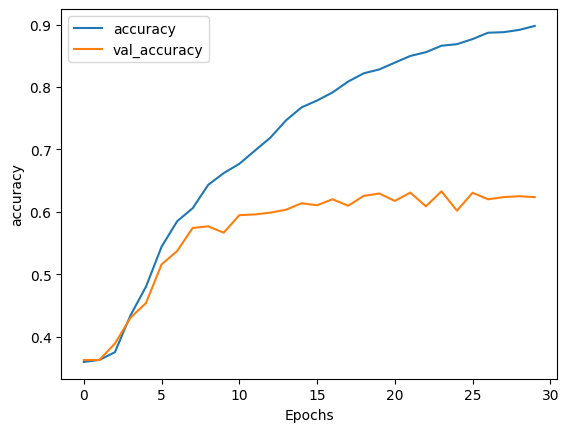

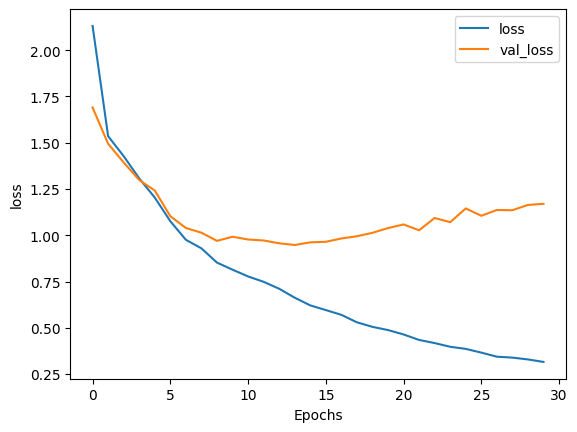

In [24]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [25]:
df_test = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')
df_test.head()

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [26]:
pred_texts = df_test['full_text'].tolist()
tokenized_pred_texts = [tokenizer.encode(pred_text).ids for pred_text in pred_texts]
padded_pred_texts = pad_sequences(tokenized_pred_texts, maxlen=max_length, padding='post')
numpy_pred_texts = np.array(padded_pred_texts)

In [27]:
preds = model.predict(numpy_pred_texts)
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


array([[1.7371505e-04, 9.4002679e-02, 9.0418941e-01, 1.6031343e-03,
        2.5030131e-05, 5.9961108e-06],
       [1.8041105e-04, 6.3780978e-02, 9.3263322e-01, 3.3854346e-03,
        1.5366486e-05, 4.5984943e-06],
       [5.7867651e-06, 1.9229332e-04, 1.2531699e-01, 8.5367095e-01,
        1.9602962e-02, 1.2110838e-03]], dtype=float32)

In [28]:
max_preds = np.argmax(preds, axis=1)
res_lst = max_preds + 1
res_lst

array([3, 3, 4])

In [29]:
df_sub = pd.DataFrame()
df_sub['essay_id'] = df_test['essay_id']
df_sub

,essay_id
0,000d118
1,000fe60
2,001ab80


In [30]:
df_sub['score'] = res_lst.transpose()
df_sub['score'] = df_sub['score'].astype('int')
df_sub

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


In [31]:
df_sub.to_csv('submission.csv', header=True, index=False)

In [32]:
import gc

gc.collect()

end = datetime.now()
print(end)

2024-05-29 03:26:52.684584
